# Embeddings to test

* UMAP
* t-SNE
* Parametric UMAP (part of UMAP)
* DenseMap (part of UMAP)
* [PacMap](https://github.com/YingfanWang/PaCMAP)
* [TriMap](https://github.com/eamid/trimap)
* PCA
* Laplacian eigenmaps
* MDS
* Isomap
* [MDE](https://github.com/cvxgrp/pymde)
* [PHATE](https://github.com/KrishnaswamyLab/PHATE)
* ForceAtlas2
* dbMAP


# Experiments

* distance/distance-rank preservation with varying ```n_neighbors```, ```n_components``` and ```min_dist```, measured with Pearson's corr.
* hierarchical embedding: original -> 1000d -> 100d -> 2d
* negative test: does it magically create clusters? Test using a high dimensional Gaussian


Metrics:
* Spearman rank correlation between samples
* Pearson correlation of distances
* Distance correlation of distances
* Average Jaccard distance
* kNN accuracy and recall


In [1]:
%load_ext autoreload
%autoreload 1
%aimport omic_helpers
%matplotlib inline

from omic_helpers.graph import embedding as graph_embedding
from omic_helpers.graph import clustering as graph_clustering


from sklearn import datasets
from sklearn.preprocessing import StandardScaler, QuantileTransformer, RobustScaler, MinMaxScaler, FunctionTransformer
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chisquare, chi2_contingency, pearsonr
from scipy.stats import kendalltau,spearmanr, weightedtau, theilslopes, wilcoxon, ttest_rel
from scipy.spatial import distance
import dcor

import umap
import pacmap
import trimap
import pymde
import dbmap
import numba

import pandas as pd
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA, KernelPCA, SparsePCA, NMF, FactorAnalysis
from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness
from tqdm import tqdm

from scipy.sparse import csr_matrix

import gc

None
None


In [2]:
from sklearn.random_projection import GaussianRandomProjection as GRP
from sklearn.random_projection import johnson_lindenstrauss_min_dim as min_dim

from sklearn.kernel_approximation import Nystroem

In [3]:
from sklearn.metrics import rand_score, adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import KNeighborsClassifier as KNN, NeighborhoodComponentsAnalysis as NCA
from sklearn.cluster import KMeans

In [4]:
def get_intra_sample_distances(X, how='euclidean'):
    if how == 'euclidean':  
        return distance.pdist(X)

# from trimap paper 
def global_score(X, Y):
    """
    Global score, wrt PCA
    Input
    ------
    X: Instance matrix
    Y: Embedding
    """

    def global_loss_(X, Y):
        # least squares loss of embedding
        X = X - np.mean(X, axis=0)
        Y = Y - np.mean(Y, axis=0)
        A = X.T @ (Y @ np.linalg.inv(Y.T @ Y))
        return np.mean(np.power(X.T - A @ Y.T, 2))

    n_dims = Y.shape[1]
    Y_pca = PCA(n_components=n_dims).fit_transform(X)
    gs_pca = global_loss_(X, Y_pca)
    gs_emb = global_loss_(X, Y)
    return np.exp(-(gs_emb - gs_pca) / gs_pca)

- [x] 
 * [Sammon mapping](https://arxiv.org/pdf/2009.08136.pdf): 
 * landmark maximum variance unfolding 
 * Landmark MDS
 * [GSOM](https://github.com/CDAC-lab/pygsom/tree/master/gsom):  -> never mind this is a clustering method..
 * SMACOF
 * KernelPCA, PCA, SparsePCA
 * Factor Analysis
 * Isomap
 * Spectral Embedding/Laplacian eigenmap
 * UMAP
 * PacMap
 * t-SNE
 * dbMAP
 * Sammon
 * LLE
 * NMF
 * MDS
 * Trimap
 * NCA with k-means/medoids as labels
 
- [ ]
 * [IVIS](https://github.com/beringresearch/ivis): [paper](https://www.nature.com/articles/s41598-019-45301-0)
 * [FactorizedEmbeddings](https://github.com/TrofimovAssya/FactorizedEmbeddings): [paper](https://academic.oup.com/bioinformatics/article/36/Supplement_1/i417/5870511)
 * [Diffeomap](): diffeomorphic dimensionality reduction Diffeomap
 * HOPE: karateclub
    * custom autoencoder 
    * RankVisu
    * FastMap MDS: https://github.com/shawn-davis/FastMapy
    * MetricMap
    * SparseMap: https://github.com/vene/sparsemap
    * growing curvilinear component analysis
    * curvilinear distance analysis
    * autoencoder NeuroScale
    * PHATE
    * GPLVM
    * FA
    * Nonlinear PCA
    * SDNE 
    * GCN
    * Graph Factorisation
    * [opt-SNE](https://github.com/omiq-ai/Multicore-opt-SNE): 
    *  Poincare embedding : https://github.com/facebookresearch/poincare-embeddings
    * NN-graph/Parametric UMAP -> GraphSage/Node2Vec/etc.. see NetworkX and karateclub!
    * https://github.com/benedekrozemberczki/karateclub
    * [GEM benchmark](https://github.com/palash1992/GEM-Benchmark), [GEM git](https://github.com/palash1992/GEM), [GEM paper](https://www.sciencedirect.com/science/article/pii/S0950705118301540)



# testsuite
* distance preservation, 
* trustworthiness, 
* topology preservation (https://github.com/scikit-tda, https://github.com/giotto-ai/giotto-tda)


# Ideas

* Use Bolt to accelerate NN-search: https://github.com/dblalock/bolt
* benchmarks: https://www.nature.com/articles/s41598-019-45301-0
* add custom encoder: https://discuss.pytorch.org/t/extracting-reduced-dimension-data-from-autoencoder-in-pytorch/56581


# Test on genomic data

In [5]:
# RNA expression data from ~1000 lung cancer patients
RNAex = pd.read_feather("/media/bramiozo/DATA-FAST/genetic_expression/lung_cancer_2021/TCGA/Lung/Lung_RNAex.feather")
RNAex.set_index('index', inplace=True)
RNAex = RNAex.loc[:, RNAex.columns[RNAex.var(axis=0)>0].values]

In [6]:
min_dim(RNAex.shape[0], eps=0.75)

200

[]

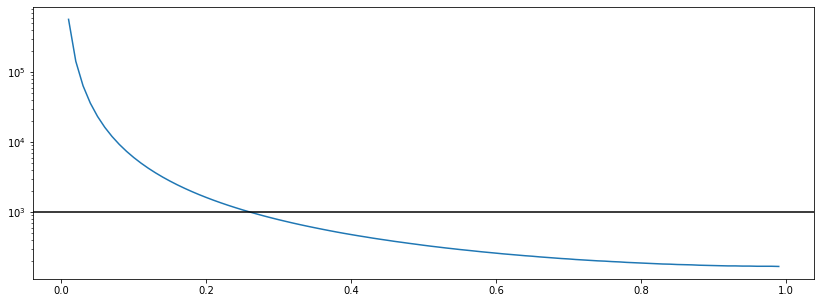

In [7]:
fig, ax = plt.subplots(figsize=(14,5))
eps_range = np.arange(1, 100, 1)/100
min_dims = [min_dim(RNAex.shape[0], eps=_eps) for _eps in eps_range]
sns.lineplot(eps_range, min_dims, ax=ax)
ax.axhline(1000, color='black')
ax.semilogy()

In [75]:
num_samples = 1000
sample_size = 250
sample_selection = np.random.randint(0,num_samples, sample_size)
n_landmarks = 75

n_n = 47
reduce_dim = 25
scaler = StandardScaler
embedder_type = 'SMACOF'


embedder = {}
embedder['nystrom'] = Nystroem(kernel='rbf', n_components=reduce_dim, random_state=1234)
embedder['umap'] = umap.UMAP(n_components=reduce_dim, densmap=False, metric='euclidean',
                             n_neighbors=n_n, min_dist=0., disconnection_distance=None)
embedder['trimap'] = trimap.TRIMAP(n_dims=reduce_dim, n_iters=2500, lr=0.15);
embedder['pacmap'] = pacmap.PaCMAP(n_dims=reduce_dim, n_neighbors=n_n)
embedder['SpectralEmbedding'] = SpectralEmbedding(n_components=reduce_dim, n_neighbors=n_n)
embedder['Isomap'] = Isomap(n_components=reduce_dim, n_neighbors=n_n)
embedder['MDS'] = MDS(n_components=reduce_dim, metric='euclidean')
embedder['KernelPCA'] = KernelPCA(n_components=reduce_dim, kernel='sigmoid')
embedder['PCA'] = PCA(n_components=reduce_dim)
embedder['SparsePCA'] = SparsePCA(n_components=reduce_dim, alpha=0.0001, n_jobs=8)
embedder['FA'] = FactorAnalysis(n_components=reduce_dim, max_iter=1000)
embedder['dbmap'] = dbmap.diffusion.Diffusor(n_components=120, ann_dist='euclidean')
embedder['LLE'] = LLE(n_components=reduce_dim, n_neighbors=n_n, method='ltsa')
embedder['NMF'] = NMF(n_components=reduce_dim, max_iter=10000)
embedder['TSNE'] = TSNE(n_components=3, perplexity=50)
embedder['Sammon'] = graph_embedding.Sammon(n_components=reduce_dim, n_neighbors=n_n,
                                            max_iterations=250, learning_rate=0.1, init_type='PCA')
embedder['MVU'] = graph_embedding.MaximumVarianceUnfolding(n_components=2, n_neighbors=n_n)
embedder['LMVU'] = graph_embedding.LandmarkMaximumVarianceUnfolding(n_components=reduce_dim, 
                                                                     n_neighbors=n_n, 
                                                                     n_landmarks=n_landmarks)
embedder['LMDS'] = graph_embedding.LandmarkMultiDimensionalScaling(n_components=reduce_dim,
                                                                     n_landmarks=n_landmarks)
embedder['GPR'] = GRP(n_components=reduce_dim, random_state=3231, eps=0.8)
embedder['NCA'] = NCA(n_components=reduce_dim, random_state=3231)


TRIMAP(n_inliers=10, n_outliers=5, n_random=5, distance=euclidean, lr=0.15, n_iters=2500, weight_adj=500.0, apply_pca=True, opt_method=dbd, verbose=True, return_seq=False)


In [ ]:
if embedder_type == 'dbmap':
    pipe = Pipeline([('scaler', scaler()), 
                     ('prepmap', embedder['dbmap']), 
                     ('reducer', embedder['umap'])])
    tts = embedder['dbmap'].fit_transform(RNAex)
    RNAembedded =np.array(pipe.fit_transform(tts))
elif embedder_type == 'NMF':    
    nonnegger = lambda x: x + 2*np.abs(np.min(x, axis=0))
    nonnegger_F = FunctionTransformer(func=nonnegger)

    pipe = Pipeline([('scaler', scaler()), 
                     ('nngr', nonnegger_F), 
                     ('reducer', embedder['NMF'])])
    RNAembedded = pipe.fit_transform(RNAex)
elif embedder_type == 'SMACOF':
    try:
        dissimilarities;
    except NameError:
        # np.abs(np.log(similarities))
        #dissimilarities = 1 - spearmanr(RNAex.values, axis=1)[0]
        dissimilarities = distance.squareform(distance.pdist(RNAex.values, metric='seuclidean'))
    RNAembedded = smacof(dissimilarities, n_components=reduce_dim, max_iter=300, eps=1e-3, n_jobs=4)[0]
elif embedder_type == 'NCA':
    pipe = Pipeline([('scaler', scaler()), 
                     ('reducer', embedder[embedder_type])]) 
    km = KMeans(n_clusters=25).fit(StandardScaler().fit_transform(RNAex))
    y = km.labels_
    RNAembedded = pipe.fit_transform(RNAex, y)
else:
    pipe = Pipeline([('scaler', scaler()), 
                     ('reducer', embedder[embedder_type])])
    RNAembedded = pipe.fit_transform(RNAex)

In [ ]:
dist_or = get_intra_sample_distances(RNAex.iloc[sample_selection,:])
dist_emb = get_intra_sample_distances(RNAembedded[sample_selection,:])

dists = {'d_or': dist_or, 'd_emb': dist_emb}
dist_preservation_overall = {'dataset': 'RNAex', 
                          'corr':dcor.distance_correlation(dist_or, dist_emb)}

fig, ax = plt.subplots(figsize=(14,9))
ax.scatter(x=dists['d_or'], y=dists['d_emb'], color='black', alpha=0.01)
mx,my = max(dists['d_or']), max(dists['d_emb'])
ax.plot([0,mx], [0, my], ls='--', c='blue')
ax.set_title('RNAex distance preservation')

# topology preservation?

In [76]:
# Rand/MI clustering
kclusterer1 = KMeans(n_clusters=10)
kclusterer1.fit(scaler().fit_transform(RNAex))

KMeans(n_clusters=10)

In [ ]:
kclusterer2 = KMeans(n_clusters=10)
kclusterer2.fit(RNAembedded)

r_score =rand_score(kclusterer1.labels_, kclusterer2.labels_)
ar_score = adjusted_rand_score(kclusterer1.labels_, kclusterer2.labels_)
mi_score = adjusted_mutual_info_score(kclusterer1.labels_, kclusterer2.labels_)
ch_score1 = calinski_harabasz_score(RNAex, kclusterer1.labels_)
ch_score2 = calinski_harabasz_score(RNAembedded, kclusterer2.labels_)

db_score1 = davies_bouldin_score(RNAex, kclusterer1.labels_)
db_score2 = davies_bouldin_score(RNAembedded, kclusterer2.labels_)

print("Distance preservation overall", dist_preservation_overall)
print("Intra-distance trustworthiness", trustworthiness(RNAex, RNAembedded))
print("Rand score", r_score)
print("Adjusted Rand score", ar_score)
print("Adjusted MI score", mi_score)
print("Calinski-Harabasz ratio, lower than 1 means better clustering for embedding", ch_score1/ch_score2)
print("David-Bouldin ratio, higher than 1 means better clustering for embedding", db_score1/db_score2)
print("Relative L2-loss", global_score(RNAex.values, RNAembedded))

In [ ]:
plot_df = pd.DataFrame(data=RNAembedded, columns=['d'+'_'+str(i) for i in range(reduce_dim)], index=RNAex.index)
meta = pd.read_feather("/media/bramiozo/DATA-FAST/genetic_expression/lung_cancer_2021/TCGA/Lung/Lung_meta.feather")
meta.set_index('SampleID', inplace=True)
plot_df = plot_df.join(meta[['Diagnosis', 'Response']], how='left')

In [ ]:
reduce_dim_ = min([6, reduce_dim])
num_rows = int(np.ceil((reduce_dim_)**2/3))
fig, ax = plt.subplots(ncols=3, nrows=num_rows, figsize=(18, 5*num_rows))
k = 0
for ki in range(reduce_dim_):
    for kj in range(reduce_dim_): 
        i = int(k/3)
        j = k%3
        if num_rows > 1:
            sns.scatterplot(data=plot_df, x='d_'+str(ki), y='d_'+str(kj), ax=ax[i,j], hue='Diagnosis', alpha=0.25)
        else:
            sns.scatterplot(data=plot_df, x='d_'+str(ki), y='d_'+str(kj), ax=ax[k], hue='Diagnosis', alpha=0.25)
        k += 1

## Benchmarking

* dimensionality versus scores

In [ ]:
dims = np.arange(2, 20, 1) # reduced dimensions
km = 10 # k-means clusters
_eps = 0.1
distance_metric = 'pearson' # pearson, spearmanr, dcor
n_neighbors = np.arange(7, 117 ,11)

num_samples = 1000
sample_size = 250
sample_selection = np.random.randint(0,num_samples, sample_size)
dist_or = get_intra_sample_distances(RNAex.iloc[sample_selection,:])
    
embedder_type = 'pacmap'

clusterer_base = KMeans(n_clusters=km)
clusterer_base.fit(scaler().fit_transform(RNAex))
ch_score1 = calinski_harabasz_score(RNAex, clusterer_base.labels_)
db_score1 = davies_bouldin_score(RNAex, clusterer_base.labels_)

scores = []
if embedder_type in ['PCA', 'KernelPCA']:
    n_neighbors = [1]
for nn in tqdm(n_neighbors):
    for dim in tqdm(dims):    
        _embedder = embedder[embedder_type]
        if embedder_type in ['trimap', 'pacmap']:
            _embedder.n_dims = dim
        else:
            _embedder.n_components = dim

        _embedder.n_neighbors = nn

        ref_embedder = GRP(n_components=dim, random_state=None, eps=_eps) # _eps

        pipe = Pipeline([('scaler', scaler()), 
                         ('reducer', _embedder)])

        ref_pipe = Pipeline([('scaler', scaler()), 
                         ('reducer', ref_embedder)])

        embedding = pipe.fit_transform(RNAex)
        ref_embedding = ref_pipe.fit_transform(RNAex)

        clusterer = KMeans(n_clusters=km)
        clusterer.fit(embedding)

        ref_clusterer = KMeans(n_clusters=km)
        ref_clusterer.fit(ref_embedding)

        ####################
        # get metrics ######
        ####################

        dist_emb = get_intra_sample_distances(embedding[sample_selection,:])
        if distance_metric=='dcor':
            dist_cor = dcor.distance_correlation(dist_or, dist_emb)
        elif distance_metric=='pearson':
            dist_cor = pearsonr(dist_or, dist_emb)[0]
        elif distance_metric=='spearman':
            dist_cor = spearmanr(dist_or, dist_emb)[0]
        
        trust = trustworthiness(RNAex, embedding)

        r_score =rand_score(clusterer_base.labels_, clusterer.labels_)
        ar_score = adjusted_rand_score(clusterer_base.labels_, clusterer.labels_)
        mi_score = adjusted_mutual_info_score(clusterer_base.labels_, clusterer.labels_)

        ch_score2 = calinski_harabasz_score(embedding, clusterer.labels_)
        db_score2 = davies_bouldin_score(embedding, clusterer.labels_)

        rel_ch_score = ch_score1/ch_score2
        rel_db_score = db_score1/db_score2

        scores.append({'dim':dim, 'dist_cor': dist_cor, 'trust': trust,
                       'rand': r_score, 'adj_rand': ar_score, 'adj_mi': mi_score,
                       'ch_score': ch_score2, 'db_score': db_score2, 
                       'rel_ch_score': rel_ch_score , 'rel_db_score': rel_db_score,   
                       'neighbors': nn, 'embedder': embedder_type})


        dist_emb = get_intra_sample_distances(ref_embedding[sample_selection,:])
        dist_cor = dcor.distance_correlation(dist_or, dist_emb)

        trust = trustworthiness(RNAex, ref_embedding)

        r_score =rand_score(clusterer_base.labels_, ref_clusterer.labels_)
        ar_score = adjusted_rand_score(clusterer_base.labels_, ref_clusterer.labels_)
        mi_score = adjusted_mutual_info_score(clusterer_base.labels_, ref_clusterer.labels_)

        ch_score2 = calinski_harabasz_score(ref_embedding, ref_clusterer.labels_)
        db_score2 = davies_bouldin_score(ref_embedding, ref_clusterer.labels_)

        rel_ch_score = ch_score1/ch_score2
        rel_db_score = db_score1/db_score2

        scores.append({'dim':dim, 'dist_cor': dist_cor, 'trust': trust,
                       'rand': r_score, 'adj_rand': ar_score, 'adj_mi': mi_score,
                       'ch_score': ch_score2, 'db_score': db_score2,                    
                       'rel_ch_score': rel_ch_score , 'rel_db_score': rel_db_score,   
                       'neighbors': nn, 'embedder': 'GRP'})
scores_df = pd.DataFrame(scores)

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(17,18))
sns.lineplot(data=scores_df, x='dim', y='dist_cor', hue='embedder', ax=ax[0,0])
sns.lineplot(data=scores_df, x='dim', y='trust', hue='embedder', ax=ax[0,1])
sns.lineplot(data=scores_df, x='dim', y='rand', hue='embedder', ax=ax[0,2])

sns.lineplot(data=scores_df, x='dim', y='adj_rand', hue='embedder', ax=ax[1,0])
sns.lineplot(data=scores_df, x='dim', y='adj_mi', hue='embedder', ax=ax[1,1])
sns.lineplot(data=scores_df, x='dim', y='ch_score', hue='embedder', ax=ax[1,2])

sns.lineplot(data=scores_df, x='dim', y='db_score', hue='embedder', ax=ax[2,0])
sns.lineplot(data=scores_df, x='dim', y='rel_ch_score', hue='embedder', ax=ax[2,1])
sns.lineplot(data=scores_df, x='dim', y='rel_db_score', hue='embedder', ax=ax[2,2])

fig.suptitle(f"Embedder type: {embedder_type}")


# Neural networks for embeddings

work in progress

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch import Tensor
from torchvision import datasets

In [9]:
# utility functions
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device

device = get_device()
print(f"Using: {device}")

Using: cuda


In [55]:
class DenseEncoder(nn.Module):
    def __init__(self, in_features, out_features, layer_sizes, dropout_ratio=0.25):
        super(DenseEncoder, self).__init__()
        
        layer_sizes = [in_features] + layer_sizes
        
        self.seq= nn.Sequential()       
        for idx in range(0, len(layer_sizes)-1):
            self.seq.add_module('ENC_fc_'+str(idx), nn.Linear(in_features=layer_sizes[idx], 
                                                              out_features=layer_sizes[idx+1]))
            self.seq.add_module('ENC_relu_'+str(idx), nn.ReLU())
            self.seq.add_module('ENC_dropout'+str(idx), nn.Dropout(dropout_ratio))
        self.seq.add_module('ENC_fcF', nn.Linear(in_features=layer_sizes[-1], out_features=out_features))
        
    def forward(self, x):
        return self.seq(x)

class DenseDecoder(nn.Module):
    def __init__(self, in_features, out_features, layer_sizes):
        super(DenseDecoder, self).__init__()
        
        layer_sizes = list(reversed(layer_sizes))
        layer_sizes = [out_features] + layer_sizes
        
        self.seq= nn.Sequential()
        for idx in range(0, len(layer_sizes)-1):
            self.seq.add_module('DEC_fc_'+str(idx), nn.Linear(in_features=layer_sizes[idx], 
                                                              out_features=layer_sizes[idx+1]))
            self.seq.add_module('DEC_relu_'+str(idx), nn.ReLU())
        self.seq.add_module('DEC_fcF', nn.Linear(in_features=layer_sizes[-1], out_features=in_features))
        
    def forward(self, x):
        return self.seq(x)
    
class DenseAE(nn.Module):
    
    def __init__(self, **kwargs):
        super(DenseAE, self).__init__()
        self.encoder = DenseEncoder(in_features=kwargs['in_features'], 
                                    out_features=kwargs['out_features'],
                                    layer_sizes=kwargs['layer_sizes'])
        self.decoder = DenseDecoder(in_features=kwargs['in_features'], 
                                    out_features=kwargs['out_features'],
                                    layer_sizes=kwargs['layer_sizes'])

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [56]:
class ConvEncoder(nn.Module):
    def __init__(self, in_features, out_features, layer_sizes):
        super(ConvEncoder, self).__init__()
        
        self.seq = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=8, stride=4, padding=0, 
                      bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=0, 
                      bias=False),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=out_features, kernel_size=3, stride=1, padding=0, 
                      bias=True)
        )
        
    def forward(self, x):
        return self.seq(x) 

class ConvDecoder(nn.Module):
    def __init__(self, in_features, out_features, layer_sizes):
        super(ConvDecoder, self).__init__()
        
        self.seq = nn.Sequential(
            nn.ConvTranspose1d(in_channels=out_features, out_channels=64, kernel_size=3, stride=1, padding=0, 
                               bias=False),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=0, 
                               bias=False),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=8, stride=4, padding=0, 
                               bias=True),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.seq(x) 
    
class ConvAE(nn.Module):
    
    def __init__(self, **kwargs):
        super(ConvAE, self).__init__()
        self.encoder = ConvEncoder(in_features=kwargs['in_features'], 
                                    out_features=kwargs['out_features'],
                                    layer_sizes=kwargs['layer_sizes'])
        self.decoder = ConvDecoder(in_features=kwargs['in_features'], 
                                    out_features=kwargs['out_features'],
                                    layer_sizes=kwargs['layer_sizes'])

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [12]:
class MixedColumnarDataset(Dataset):
    """Dataset class for column dataset.
    Args:
       cats (list of str): List of the name of columns contain
                           categorical variables.
       conts (list of str): List of the name of columns which 
                           contain continuous variables.
       y (Tensor, optional): Target variables.
    """
    def __init__(self, df, cat_flds):       
        conts = [c.values for n,c in df.items()]
        
        n = len(conts[0])
        self.conts = np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1))
        self.len = len(df)
        
    def __len__(self): 
        return self.len   
    
    def __getitem__(self, idx):
        return self.conts[idx]
    
outputs = None
def get_embeddings(model, x, ntype = 'dense'):
    if ntype == 'dense':
        return model.encoder.forward(Tensor(x).cuda()).cpu().detach().numpy()
    elif ntype == 'conv':
        return model.encoder.forward(Tensor(x).unsqueeze(1).cuda()).cpu().detach().numpy()

def train(net, trainloader, optimizer, NUM_EPOCHS, ntype='conv'):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data in trainloader:
            if ntype=='conv':
                dataTensor = Tensor(data).unsqueeze(1)
                optimizer.zero_grad()            
                outputs = n_net(dataTensor.cuda())
                loss = criterion(outputs, dataTensor.cuda())
            else:
                optimizer.zero_grad()            
                outputs = n_net(Tensor(data).cuda())
                loss = criterion(outputs, data.cuda())                
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        print(f"-------------Train loss: {loss}, epoch: {epoch}")

    return train_loss

In [38]:
RNAex_normalised = pd.DataFrame(data=MinMaxScaler().fit_transform(np.log(RNAex.values+1)), 
                                columns=RNAex.columns.tolist())

In [57]:
nntype='dense'
if nntype == 'dense':
    n_net = DenseAE(in_features=RNAex.shape[1], out_features=8, layer_sizes=[48,32,32])
    n_net.to(device)
elif nntype == 'conv':
    n_net = ConvAE(in_features=RNAex.shape[1], out_features=8, layer_sizes=[64,32,32,16])
    n_net.to(device)

In [69]:
NUM_EPOCHS = 100
LEARNING_RATE = 5e-5

criterion = nn.MSELoss()
net_optimizer = optim.Adam(n_net.parameters(), lr=LEARNING_RATE, weight_decay=0)

In [70]:
train_dl = DataLoader(MixedColumnarDataset(RNAex_normalised, []), batch_size=96, shuffle=True)

In [ ]:
train_loss = train(n_net, train_dl, net_optimizer, NUM_EPOCHS, ntype=nntype)
torch.cuda.empty_cache()
ae_embs = get_embeddings(n_net, RNAex_normalised.values, ntype=nntype)

<AxesSubplot:xlabel='d_1', ylabel='d_2'>

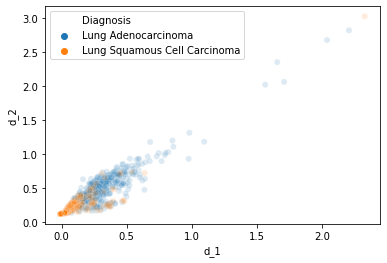

In [73]:
plot_df = pd.DataFrame(data=ae_embs, columns=['d_'+str(i) for i in range(8)], index=RNAex.index)
meta = pd.read_feather("/media/bramiozo/DATA-FAST/genetic_expression/lung_cancer_2021/TCGA/Lung/Lung_meta.feather")
meta.set_index('SampleID', inplace=True)
plot_df = plot_df.join(meta[['Diagnosis', 'Response']], how='left')
sns.scatterplot(data=plot_df, x='d_1', y='d_2', hue='Diagnosis', alpha=0.15)

In [80]:
kclusterer2 = KMeans(n_clusters=10)
kclusterer2.fit(ae_embs)

dist_or = get_intra_sample_distances(RNAex.iloc[sample_selection,:])
dist_emb = get_intra_sample_distances(ae_embs[sample_selection,:])

dists = {'d_or': dist_or, 'd_emb': dist_emb}
dist_preservation_overall = {'dataset': 'RNAex', 
                          'corr':dcor.distance_correlation(dist_or, dist_emb)}

r_score =rand_score(kclusterer1.labels_, kclusterer2.labels_)
ar_score = adjusted_rand_score(kclusterer1.labels_, kclusterer2.labels_)
mi_score = adjusted_mutual_info_score(kclusterer1.labels_, kclusterer2.labels_)
ch_score1 = calinski_harabasz_score(RNAex, kclusterer1.labels_)
ch_score2 = calinski_harabasz_score(ae_embs, kclusterer2.labels_)

db_score1 = davies_bouldin_score(RNAex, kclusterer1.labels_)
db_score2 = davies_bouldin_score(ae_embs, kclusterer2.labels_)

print("Distance preservation overall", dist_preservation_overall)
print("Intra-distance trustworthiness", trustworthiness(RNAex, ae_embs))
print("Rand score", r_score)
print("Adjusted Rand score", ar_score)
print("Adjusted MI score", mi_score)
print("Calinski-Harabasz ratio, lower than 1 means better clustering for embedding", ch_score1/ch_score2)
print("David-Bouldin ratio, higher than 1 means better clustering for embedding", db_score1/db_score2)
print("Relative L2-loss", global_score(RNAex.values, ae_embs))

Distance preservation overall {'dataset': 'RNAex', 'corr': 0.37245995146171595}
Intra-distance trustworthiness 0.7368883121147329
Rand score 0.694367915219604
Adjusted Rand score 0.27375788180239347
Adjusted MI score 0.40015047305337825
Calinski-Harabasz ratio, lower than 1 means better clustering for embedding 0.02884254649759499
David-Bouldin ratio, higher than 1 means better clustering for embedding 3.8883397543568066
Relative L2-loss 0.5207016863928956


The distance correlation/preservation and the trustworthiness metrics are not suitable metrics to qualify embeddings as they cannot distinguish between neighborhoods in the original space. Even if points are projected randomly they can have similar distances in lower dimensional space, in fact the higher the dimensionality of the embeddeds space the more possibilities there are to randomly obtain similar intra-point distances.

We would expect that if we increase the embedded dimensions we get closer to the performance of random projections in terms of intra-distance preservations.

# Test on CELLDYN data

# Semi-supervised UMAP

The main flavor is to add labels for the different clusters we know we want to 
see. This can be based on a clustering on a sample set of the original data (perhaps also a selection of features).

Possible methods:
* UMAP
* NCA
* knn-based SSL
* SSL-trained neural network

Labels can be:
* k-means/medoids clusters on the original dataset
* phenotypes

# Parametric UMAP

* Create nearest-neighbor graph with fuzzy simplicials
* Apply graph embedder

# Anchored embedding

# Distance preserving embedding

* Siamese twins networks
* distance as outcome
* pairs as input

The method IVIS seems to use this idea.

# Ranking based embedder

# Multi-patch UMAP

The core assumption of UMAP is that all points lie on the same manifold. What if we split our data in dense patches prior to the creation of the fuzzy simplicials? 

To make this tractable this split should be computationally in-expensive. One way to go about is to treat overlapping regions with a sufficient number of samples as patches. The embeddings associated with these patches can later be combined.



# Multi-sample UMAP


* $N$ sampled UMAP embedders with/without minimal perturbations
* aligned using Procrustes
* uniform scaling
* concensus distance determination

# Landmarkbased embeddings coupled to sparse exemplar finders

Instead of random landmarks we can use exemplars based on 
* points closest to centroids
* exemplars based on e.g. affinity propagation